**Steps for Fine-tuning the Model for Cell-Cell Communication:**

1.  **Prepare Your Environment:** Ensure you have the necessary Python libraries installed (as indicated in the original script).
2.  **Download Datasets and Pre-trained Model:** Obtain the gene and protein expression data files for training and testing, as well as the pre-trained model files.
3.  **Organize File Paths:** Make sure the paths to your data files and the pre-trained model are correctly specified.
4.  **Execute the Python Script:** Run the Python script from your terminal, providing the required parameters to control the fine-tuning process.
5.  **Monitor Training (if applicable):** If you are training (`--do_train`), observe the output in your terminal to track the progress (loss, learning rate, etc.).
6.  **Locate Output Files:** After the script finishes, the fine-tuned model, generated feature files and predicted results will be saved in the directory specified by the `--save_dir` parameter (Please download our dataset, fine-tuned models, generated feature files from https://drive.google.com/drive/folders/1wV8zkBePlZiPpAlAx_xssUkmWYpCzhuT?usp=drive_link).

**Python Command to Run Fine-tuning:**

```bash
python finetune.py --mode train --species human --rna_file /home/jiboya/captain/data/rna.h5ad --adt_file /home/jiboya/captain/data/adt.h5ad --save_dir /home/jiboya/captain/results --load_model /home/jiboya/captain/model --seed 0 --mask_ratio 0.4 --epochs 100 --batch_size 15 --lr 1e-3
```
**Python Command to cell surface protein prediction and imputation:**
```bash
python finetune.py --mode eval --species human --rna_file /home/jiboya/captain/data/rna.h5ad --adt_file /home/jiboya/captain/data/adt.h5ad --save_dir /home/jiboya/captain/results --load_model /home/jiboya/captain/model
```

**Explanation of the Command:**
* `--mode`: Sets the script to training or evaluation mode.
* `--species`: Specifies the species of the dataset. Use human or mouse. Default is human.
* `--rna_file`: Required. Provides the path to the RNA data file (e.g., rna.h5ad).
* `--adt_file`: Required. Provides the path to the ADT (protein expression) data file (e.g., adt.h5ad).
* `--save_dir`: Sets the directory where the training results (model checkpoints, logs, etc.) will be saved. Default is /home/jiboya/captain/results.
* `--load_model`: Optional. Specifies the path to a directory containing a pre-trained model to load for further training or fine-tuning.
* `--seed`: Sets the random seed for reproducibility.
* `--mask_ratio`: Defines the ratio of input data to be masked during training (a common technique in self-supervised learning).
* `--epochs`: Sets the number of times the entire training dataset will be passed through the model during training.
* `--batch_size`: Determines the number of data samples processed together in one batch during training.
* `--lr`: Sets the learning rate, controlling the step size during the optimization process.

Remember to adjust the file paths according to the actual location of your data and pre-trained model. You can also modify other parameters as needed based on your specific requirements.



In [16]:
import numpy as np
import pandas as pd
import scanpy as sc
import liana as li
import mudata as mu
from matplotlib import pyplot as plt
prot = sc.read('/home/jiboya/Captain/ccc/citeseq_prot.h5ad')
rna = sc.read('/home/jiboya/Captain/ccc/citeseq_rna.h5ad')


In [2]:
import numpy as np
import anndata as ad
import pandas as pd  
import pickle as pkl
with open('/home/jiboya/Captain/ccc/predicted_adt_data.pickle', 'rb') as fp:
    predicted_adt_data = pkl.load(fp)
with open('/home/jiboya/Captain/token_dict/adt_token_dict.pickle', 'rb') as fp:
    adt_token_dict = pkl.load(fp)
predicted_adt_data = np.array(predicted_adt_data)
cont = np.array(predicted_adt_data)

prot = ad.AnnData(
    X=cont,
    obs=rna.obs.copy(), 
    obsm=rna.obsm.copy(), 
    var=pd.DataFrame(index=list(adt_token_dict.keys()))
)

In [3]:
mdata = mu.MuData({'rna': rna, 'prot': prot})
# make sure that cell type is accessible
mdata.obs['celltype'] = mdata.mod['rna'].obs['celltype'].astype('category')
# inspect the object
mdata

# Obtain a ligand-receptor resource of interest
resource = li.rs.select_resource(resource_name='consensus')
# Append AB: to the receptor names
resource['receptor'] = 'AB:' + resource['receptor']

# Append AB: to the protein modality
mdata.mod['prot'].var_names = 'AB:' + mdata.mod['prot'].var.index

/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [4]:
mdata.write_h5mu("/home/jiboya/Captain/ccc/mdata.h5mu")

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import liana as li
import mudata as mu
from matplotlib import pyplot as plt
mdata=mu.read_h5mu("/home/jiboya/Captain/ccc/mdata.h5mu")
# Obtain a ligand-receptor resource of interest
resource = li.rs.select_resource(resource_name='consensus')
# Append AB: to the receptor names
resource['receptor'] = 'AB:' + resource['receptor']
li.mt.cellphonedb(adata=mdata,
                     groupby='celltype',
                     # pass our modified resource
                     resource=resource,
                     # NOTE: Essential arguments when handling multimodal data
                     mdata_kwargs={
                     # Ligand-Receptor pairs are directed so we need to correctly pass
                     # `RNA` with ligands as `x_mod` and receptors as `y_mod`
                     'x_mod': 'rna',
                     'y_mod': 'prot',
                     # We use .X from the x_mod
                     'x_use_raw':False,
                     # We use .X from the y_mod
                     'y_use_raw':False,
                     # NOTE: we need to ensure that the modalities are correctly transformed
                    'x_transform':li.ut.zi_minmax,
                    'y_transform':li.ut.zi_minmax,

                    },
                  verbose=True
                  )
mdata.uns['liana_res'].to_csv("/home/jiboya/Captain/ccc/captain_cpdb_res.csv")

Using `.X`!


Using provided `resource`.
Transforming rna using zi_minmax


Using `.X`!
Converting to sparse csr matrix!


Transforming prot using zi_minmax


Using `.X`!
/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
46 features of mat are empty, they will be removed.
/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.73 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 3885 samples and 209 features


100%|██████████| 1000/1000 [00:02<00:00, 393.95it/s]


In [7]:
rna.obs['celltype'].value_counts()

celltype
CD4+ naïve T         921
CD4+ memory T        622
intermediate mono    612
CD14 mono            535
CD8+ memory T        390
NK                   207
mature B             156
pre-B                143
memory-like NK       116
CD16 mono             96
Treg                  59
pDC                   28
Name: count, dtype: int64

In [7]:

fig =li.pl.circle_plot(mdata,
                  groupby='celltype',
                  score_key='cellphone_pvals',
                  inverse_score=True,
                  source_labels='CD4+ naïve T',
                  filter_fun=lambda x: x['cellphone_pvals'] <= 0.05,
                  pivot_mode='mean', # NOTE: this will simply count the interactions, 'mean' is also available
                  figure_size=(8, 8),
                  )
# Save the plot as a PDF
fig = fig.get_figure()  # Get the Figure object from the Axes

fig.savefig("/home/jiboya/Captain/ccc/circle_plot_CD4naive.pdf",dpi=300)
plt.close(fig)

In [20]:
mdata.uns['liana_res'] = mdata.uns['liana_res'].rename(columns={'cellphone_pvals': 'captain_pvals'})
from plotnine import theme, element_text
fig =li.pl.dotplot(adata = mdata,
              colour='lr_means',
              size='captain_pvals',
              inverse_size=False, # we inverse sign since we want small p-values to have large sizes
              source_labels=['CD4+ naïve T'],
              target_labels=['CD4+ memory T', 'intermediate mono', 'CD14 mono', 'CD8+ memory T','NK','mature B','pre-B','memory-like NK'],
              figure_size=(6, 6),
              # Filter to top 10 acc to magnitude rank
              top_n=10,
              orderby='captain_pvals',
              orderby_ascending=True,
              cmap='plasma',
              return_fig=True

             )+ theme(axis_text_x=element_text(angle=45, hjust=1))

fig.save(filename="dotplot.pdf", path="/home/jiboya/Captain/ccc", dpi=300)


/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/liana/plotting/_common.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 6 in image.
/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: /home/jiboya/Captain/ccc7/dotplot.pdf
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


In [8]:
import pandas as pd

LRpairs_filter=pd.read_csv("/home/jiboya/Captain/ccc/captain_cpdb_res.csv",index_col=0)
LRpairs_filter = LRpairs_filter[
    (LRpairs_filter["source"] == "CD4+ naïve T") &
    (LRpairs_filter["target"] == "NK") &
    (LRpairs_filter["cellphone_pvals"] < 0.05)
]

# LRpairs_filter = LRpairs_filter.sort_values(by="cellphone_pvals", ascending=True).head(100)
cpdb_res=pd.read_csv("/home/jiboya/Captain/ccc/linana/cpdb_res.csv",index_col=0)
cpdb_res = cpdb_res[
    (cpdb_res["source"] == "CD4+ naïve T") &
    (cpdb_res["target"] == "NK") &
    (cpdb_res["cellphone_pvals"] < 0.05)
]
# cpdb_res = cpdb_res.sort_values(by="cellphone_pvals", ascending=True).head(100)

cellchat_res=pd.read_csv("/home/jiboya/Captain/ccc/linana/cellchat_res.csv",index_col=0)
cellchat_res = cellchat_res[
    (cellchat_res["source"] == "CD4+ naïve T") &
    (cellchat_res["target"] == "NK") &
    (cellchat_res["cellchat_pvals"] < 0.05)
]
# cellchat_res = cellchat_res.sort_values(by="cellchat_pvals", ascending=True).head(100)
connectome_res=pd.read_csv("/home/jiboya/Captain/ccc/linana/connectome_res.csv",index_col=0)
connectome_res = connectome_res[
    (connectome_res["source"] == "CD4+ naïve T") &
    (connectome_res["target"] == "NK") &
    (connectome_res["scaled_weight"] > 0.5)
]
# connectome_res = connectome_res.sort_values(by="scaled_weight", ascending=False).head(100)
natmi_res=pd.read_csv("/home/jiboya/Captain/ccc/linana/natmi_res.csv",index_col=0)
natmi_res = natmi_res[
    (natmi_res["source"] == "CD4+ naïve T") &
    (natmi_res["target"] == "NK") &
    (natmi_res["spec_weight"] > 0.05)
]
# natmi_res = natmi_res.sort_values(by="spec_weight", ascending=False).head(100)
singlecellsignalr_res=pd.read_csv("/home/jiboya/Captain/ccc/linana/singlecellsignalr_res.csv",index_col=0)
singlecellsignalr_res = singlecellsignalr_res[
    (singlecellsignalr_res["source"] == "CD4+ naïve T") &
    (singlecellsignalr_res["target"] == "NK") &
    (singlecellsignalr_res["lrscore"] > 0.5)
]
# singlecellsignalr_res = singlecellsignalr_res.sort_values(by="lrscore", ascending=False).head(100)

In [22]:
cpdb_res

,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lr_means,cellphone_pvals
1363,CD40LG,CD40LG,0.068643,0.320304,AB:CD80,AB:CD80,0.113006,1.0,CD4+ naïve T,NK,0.090824,0.0


/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/home/jiboya/anaconda3/envs/linana/lib/python3.9/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/jiboya/anaconda3/envs/linana/lib/python3.9

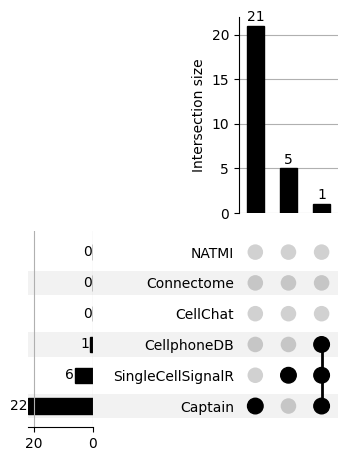

In [17]:
lr_pairs_lrmethod=(LRpairs_filter['ligand_complex'] + LRpairs_filter['receptor_complex']).tolist()
lr_pairs_cpdb = (cpdb_res['ligand_complex'] + cpdb_res['receptor_complex']).tolist()
lr_pairs_cellchat = (cellchat_res['ligand_complex'] + cellchat_res['receptor_complex']).tolist()
lr_pairs_connectome = (connectome_res['ligand_complex'] + connectome_res['receptor_complex']).tolist()
lr_pairs_natmi = (natmi_res['ligand_complex'] + natmi_res['receptor_complex']).tolist()
lr_pairs_singlecellsignalr = (singlecellsignalr_res['ligand_complex'] + singlecellsignalr_res['receptor_complex']).tolist()
(lr_pairs_lrmethod,lr_pairs_cpdb,lr_pairs_cellchat,lr_pairs_connectome,lr_pairs_natmi,lr_pairs_singlecellsignalr)
from upsetplot import from_contents,plot
import matplotlib.pyplot as plt
animals = from_contents(
    {
    'Captain': lr_pairs_lrmethod,
    'CellphoneDB': lr_pairs_cpdb,
    'CellChat': lr_pairs_cellchat,
    'Connectome': lr_pairs_connectome,
    'NATMI': lr_pairs_natmi,
    'SingleCellSignalR': lr_pairs_singlecellsignalr
}
)

from upsetplot import UpSet
# Explicitly create the figure with the desired size
fig = plt.figure(figsize=(6, 10)) # Adjust width and height as needed

ax_dict = UpSet(animals, subset_size="count",show_counts=True)
ax_dict=ax_dict.plot(fig=fig)

plt.savefig("/home/jiboya/Captain/ccc/upset_plot_CD4naive_NK.pdf",dpi=300)

In [29]:

set_lrmethod = set(lr_pairs_lrmethod)
set_cpdb = set(lr_pairs_cpdb)
set_cellchat = set(lr_pairs_cellchat)
set_connectome = set(lr_pairs_connectome)
set_natmi = set(lr_pairs_natmi)
set_singlecellsignalr = set(lr_pairs_singlecellsignalr)

combined_other_sets = set_cpdb | set_cellchat | set_connectome | set_natmi | set_singlecellsignalr

unique_to_lrmethod = set_lrmethod - combined_other_sets

unique_to_lrmethod_list = list(unique_to_lrmethod)

print("特有的元素:", unique_to_lrmethod_list)

特有的元素: ['FLT3LGAB:EGFR', 'TGFB1AB:SDC1', 'PTPN6AB:EGFR', 'CD99AB:CD81', 'TGFB1AB:EGFR', 'COPAAB:CD74', 'AREGAB:MERTK', 'AREGAB:EGFR', 'ARF4AB:EGFR', 'VEGFBAB:MERTK', 'CD48AB:CD244', 'ANXA1AB:EGFR', 'CMTM8AB:EGFR', 'CD40LGAB:CD47', 'YBX1AB:EGFR', 'MIFAB:CD74', 'FLT3LGAB:MERTK', 'CD40LGAB:CD83', 'CLEC2DAB:CD161', 'VEGFBAB:EGFR', 'MIFAB:EGFR']


In [18]:
unique_to_lrmethod_list=['FLT3LGAB:EGFR', 'TGFB1AB:SDC1', 'PTPN6AB:EGFR', 'CD99AB:CD81', 'TGFB1AB:EGFR', 'COPAAB:CD74', 'AREGAB:MERTK', 'AREGAB:EGFR', 'ARF4AB:EGFR', 'VEGFBAB:MERTK', 'CD48AB:CD244', 'ANXA1AB:EGFR', 'CMTM8AB:EGFR', 'CD40LGAB:CD47', 'YBX1AB:EGFR', 'MIFAB:CD74', 'FLT3LGAB:MERTK', 'CD40LGAB:CD83', 'CLEC2DAB:CD161', 'VEGFBAB:EGFR', 'MIFAB:EGFR']
gene_list=[]
adt_list=[]
for i in unique_to_lrmethod_list:
    
    gene_list.append(i.split("AB:")[0])
    adt_list.append(i.split("AB:")[1])


In [81]:

import gseapy as gp


enr = gp.enrichr(
    gene_list=gene_list,
    gene_sets=["GO_Biological_Process_2025" ,"WikiPathways_2024_Human", "Reactome_Pathways_2024"],
    organism="Human",
    outdir="/home/jiboya/Captain/ccc", 
    cutoff=0.05  
)


maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 30 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'B', 'G', 'O', 'P', 'a', 'c', 'd', 'e', 'five', 'g', 'hyphen', 'i', 'j', 'l', 'nonmarkingreturn', 'o', 'parenleft', 'parenright', 'r', 's', 'space', 't', 'two', 'u', 'underscore', 'v', 'zero']
Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 19, 21, 24, 36, 37, 42, 50, 51, 66, 68, 70, 71, 72, 74, 76, 77, 79, 82, 85, 86, 87, 88, 89]
Closed glyph list over 'GSUB': 30 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'B', 'G', 'O', 'P', 'a', 'c', 'd', 'e', 'five', 'g', 'hyphen', 'i', 'j', 'l', 'nonmarkingreturn', 'o', 'parenleft', 'parenright', 'r', 's', 'space', 't', 'two', 'u', 'underscore', 'v', 'zero']
Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 19, 21, 24, 36, 37, 42, 50, 51, 66, 68, 70, 71, 72, 74, 76, 77, 79, 82, 85, 86, 87, 88, 89]
Closing glyph list over 'gl

In [66]:
gp.get_library_name(organism='Human')

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_Cell

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.weight'] = 'bold'
import gseapy as gp
enr2 = gp.enrichr(
    gene_list=adt_list,
    gene_sets=["GO_Cellular_Component_2025", "GO_Molecular_Function_2025"],
    organism="Human",
    outdir="/home/jiboya/Captain/ccc", 
    cutoff=0.05
)